# Training in Brax

Once an environment is created in brax, we can quickly train it using brax's built-in training algorithms. Let's try it out!

In [1]:
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a GPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'GPU'** in the dropdown.

# import functools

import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display, IFrame

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

import flax
# from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

# import sys
# sys.path.append('../')

# from envs.reacher import Reacher

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

In [2]:
from typing import Tuple
from brax import base
from brax import math
from brax.envs.base import PipelineEnv, State
from brax.io import mjcf
from etils import epath
import jax
from jax import numpy as jnp

# This is based on original Reacher environment from Brax
# https://github.com/google/brax/blob/main/brax/envs/reacher.py

class Reacher(PipelineEnv):
    def __init__(self, backend="generalized", dense_reward: bool = False, **kwargs):
        path = epath.resource_path("brax") / "envs/assets/reacher.xml"
        sys = mjcf.load(path)

        n_frames = 2

        if backend in ["spring", "positional"]:
            sys = sys.tree_replace({"opt.timestep": 0.005})
            sys = sys.replace(
                actuator=sys.actuator.replace(gear=jnp.array([25.0, 25.0]))
            )
            n_frames = 4

        kwargs["n_frames"] = kwargs.get("n_frames", n_frames)

        super().__init__(sys=sys, backend=backend, **kwargs)
        self.dense_reward = dense_reward
        self.state_dim = 10
        self.goal_indices = jnp.array([4, 5, 6])
        self.goal_reach_thresh = 0.05

    def reset(self, rng: jax.Array) -> State:
        rng, rng1, rng2 = jax.random.split(rng, 3)

        q = self.sys.init_q + jax.random.uniform(
            rng1, (self.sys.q_size(),), minval=-0.1, maxval=0.1
        )
        qd = jax.random.uniform(
            rng2, (self.sys.qd_size(),), minval=-0.005, maxval=0.005
        )

        # set the target q, qd
        _, target = self._random_target(rng)
        self.target = target
        q = q.at[2:].set(target)
        qd = qd.at[2:].set(0)

        pipeline_state = self.pipeline_init(q, qd)

        obs = self._get_obs(pipeline_state)
        reward, done, zero = jnp.zeros(3)
        metrics = {
            "reward_dist": zero,
            "reward_ctrl": zero,
            "success": zero,
            "dist": zero
        }
        state = State(pipeline_state, obs, reward, done, metrics)
        return state

    def step(self, state: State, action: jax.Array) -> State:
        pipeline_state = self.pipeline_step(state.pipeline_state, action)
        obs = self._get_obs(pipeline_state)

        target_pos = pipeline_state.x.pos[2]
        tip_pos = (
            pipeline_state.x.take(1)
            .do(base.Transform.create(pos=jnp.array([0.11, 0, 0])))
            .pos
        )
        tip_to_target = target_pos - tip_pos
        dist = jnp.linalg.norm(tip_to_target)
        reward_dist = -math.safe_norm(tip_to_target)
        success = jnp.array(dist < self.goal_reach_thresh, dtype=float)

        if self.dense_reward:
            reward = reward_dist
        else:
            reward = success

        state.metrics.update(
            reward_dist=reward_dist,
            success=success,
            dist=dist
        )
        return state.replace(pipeline_state=pipeline_state, obs=obs, reward=reward)

    def _get_obs(self, pipeline_state: base.State) -> jax.Array:
        """Returns egocentric observation of target and arm body."""
        theta = pipeline_state.q[:2]
        target_pos = pipeline_state.x.pos[2]
        tip_pos = (
            pipeline_state.x.take(1)
            .do(base.Transform.create(pos=jnp.array([0.11, 0, 0])))
            .pos
        )
        tip_vel = (
            base.Transform.create(pos=jnp.array([0.11, 0, 0]))
            .do(pipeline_state.xd.take(1))
            .vel
        )
        return jnp.concatenate(
            [
                # state
                jnp.cos(theta),
                jnp.sin(theta),
                tip_pos,
                tip_vel,
                # target/goal
                target_pos,
            ]
        )

    def _random_target(self, rng: jax.Array) -> Tuple[jax.Array, jax.Array]:
        """Returns a target location in a random circle slightly above xy plane."""
        rng, rng1, rng2 = jax.random.split(rng, 3)
        dist = 0.2 * jax.random.uniform(rng1)
        ang = jnp.pi * 2.0 * jax.random.uniform(rng2)
        target_x = dist * jnp.cos(ang)
        target_y = dist * jnp.sin(ang)
        return rng, jnp.array([target_x, target_y])

First let's pick an environment and a backend to train an agent in.

Recall from the [Brax Basics](https://github.com/google/brax/blob/main/notebooks/basics.ipynb) colab, that the backend specifies which physics engine to use, each with different trade-offs between physical realism and training throughput/speed. The engines generally decrease in physical realism but increase in speed in the following order: `generalized`,  `positional`, then `spring`.


In [3]:
#@title Load Env { run: "auto" }

env_name = 'reacher'  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']
backend = 'positional'  # @param ['generalized', 'positional', 'spring']

env = Reacher(backend=backend or "generalized")

# env = envs.get_environment(env_name=env_name,
#                            backend=backend)
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

# IFrame(src=f"data:text/html,{html.render(env.sys, [state.pipeline_state])}", height=480,  width=900)
html.save("initial_gcrl_reacher.html", env.sys, [state.pipeline_state]) 

# IFrame(html.render(env.sys, [state.pipeline_state], colab=False), height=480,  width=900)

# Training

Brax provides out of the box the following training algorithms:

* [Proximal policy optimization](https://github.com/google/brax/blob/main/brax/training/agents/ppo/train.py)
* [Soft actor-critic](https://github.com/google/brax/blob/main/brax/training/agents/sac/train.py)
* [Evolutionary strategy](https://github.com/google/brax/blob/main/brax/training/agents/es/train.py)
* [Analytic policy gradients](https://github.com/google/brax/blob/main/brax/training/agents/apg/train.py)
* [Augmented random search](https://github.com/google/brax/blob/main/brax/training/agents/ars/train.py)

Trainers take as input an environment function and some hyperparameters, and return an inference function to operate the environment.

# Training

Let's train the Ant policy using the `generalized` backend with PPO.

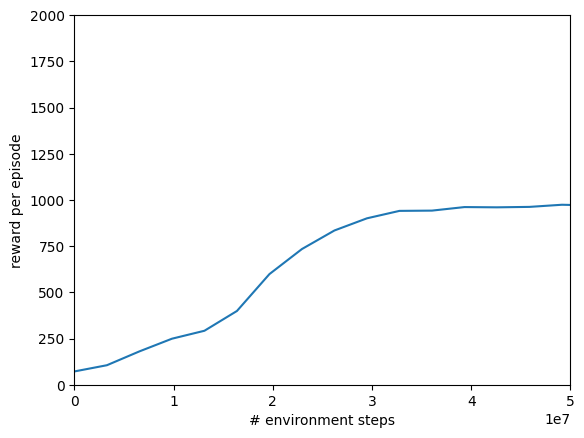

time to jit: 0:00:19.032916
time to train: 0:02:15.082290


In [4]:
#@title Training

# We determined some reasonable hyperparameters offline and share them here.
train_fn = {
  'inverted_pendulum': jax.tree_util.Partial(ppo.train, num_timesteps=2_000_000, num_evals=20, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'inverted_double_pendulum': jax.tree_util.Partial(ppo.train, num_timesteps=20_000_000, num_evals=20, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'ant': jax.tree_util.Partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=4096, batch_size=2048, seed=1),
  'humanoid': jax.tree_util.Partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=10, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=1024, seed=1),
  'reacher': jax.tree_util.Partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=4, unroll_length=50, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=256, max_devices_per_host=8, seed=1),
  'humanoidstandup': jax.tree_util.Partial(ppo.train, num_timesteps=100_000_000, num_evals=20, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=15, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=6e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'hopper': jax.tree_util.Partial(sac.train, num_timesteps=6_553_600, num_evals=20, reward_scaling=30, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=512, grad_updates_per_step=64, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  'walker2d': jax.tree_util.Partial(sac.train, num_timesteps=7_864_320, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=128, grad_updates_per_step=32, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  'halfcheetah': jax.tree_util.Partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=20, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=0.001, num_envs=2048, batch_size=512, seed=3),
  'pusher': jax.tree_util.Partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=30, num_minibatches=16, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4,entropy_cost=1e-2, num_envs=2048, batch_size=512, seed=3),
}[env_name]


max_y = {'ant': 8000, 'halfcheetah': 8000, 'hopper': 2500, 'humanoid': 13000, 'humanoidstandup': 75_000, 'reacher': 2000, 'walker2d': 5000, 'pusher': 0}[env_name]
min_y = {'reacher': 0, 'pusher': -150}.get(env_name, 0)

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [5]:
model.save_params('/tmp/params', params)
params = model.load_params('/tmp/params')
inference_fn = make_inference_fn(params)

The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [6]:
#@title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
# env = envs.create(env_name=env_name, backend=backend)

env = Reacher(backend=backend or "generalized")

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)

html.save("trained_gcrl_reacher.html", env.sys.tree_replace({'opt.timestep': env.dt}), rollout) 

HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

In [7]:
ydata

[Array(71.859375, dtype=float32),
 Array(105.50781, dtype=float32),
 Array(180.39062, dtype=float32),
 Array(248.94531, dtype=float32),
 Array(291.9922, dtype=float32),
 Array(399.0078, dtype=float32),
 Array(598.64844, dtype=float32),
 Array(734.2656, dtype=float32),
 Array(834.6953, dtype=float32),
 Array(900.46875, dtype=float32),
 Array(940.7031, dtype=float32),
 Array(942.14844, dtype=float32),
 Array(961.28906, dtype=float32),
 Array(959.9219, dtype=float32),
 Array(962.2969, dtype=float32),
 Array(973.8672, dtype=float32),
 Array(969.8125, dtype=float32),
 Array(972.78125, dtype=float32),
 Array(971.7578, dtype=float32),
 Array(974.6406, dtype=float32)]

🙌 See you soon!